***LIBRERIAS UTILIZADAS***

In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import random

import os

import pandas as pd
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 837.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 144.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 142.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.2 MB/s eta 0:00:00


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


**ACCEDER AL DATASET EN GOOGLE DRIVE**

In [ ]:
# Ruta de las carpetas de imágenes
data_dir = '/content/drive/MyDrive/datasets_tomate'

**GENERADOR DE IMAGENES Y PREPROCESAMIENTO**

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 12706 images belonging to 10 classes.
Found 2725 images belonging to 10 classes.
Found 2718 images belonging to 10 classes.


**MUESTRA LA CANTIDAD DE IMAGENES POR CATEGORIA**

Conjunto de entrenamiento:


,Categoría,Cantidad de imágenes
0,acaro_de_dos_manchas,1173
1,mancha_bacteriana,1488
2,mancha_diana,982
3,mancha_negra,700
4,mildiu_del_tomate,1336
5,moho_de_la_hoja,666
6,saludable,1112
7,septoriosis,1239
8,virus_del_mosaico_del_tomate,261
9,virus_del_rizado_amarillo_del_tomate,3749



 Conjunto de validación:


,Categoría,Cantidad de imágenes
0,acaro_de_dos_manchas,251
1,mancha_bacteriana,319
2,mancha_diana,211
3,mancha_negra,150
4,mildiu_del_tomate,286
5,moho_de_la_hoja,143
6,saludable,239
7,septoriosis,266
8,virus_del_mosaico_del_tomate,56
9,virus_del_rizado_amarillo_del_tomate,804



 Conjunto de prueba:


,Categoría,Cantidad de imágenes
0,acaro_de_dos_manchas,251
1,mancha_bacteriana,319
2,mancha_diana,210
3,mancha_negra,149
4,mildiu_del_tomate,286
5,moho_de_la_hoja,142
6,saludable,238
7,septoriosis,265
8,virus_del_mosaico_del_tomate,55
9,virus_del_rizado_amarillo_del_tomate,803


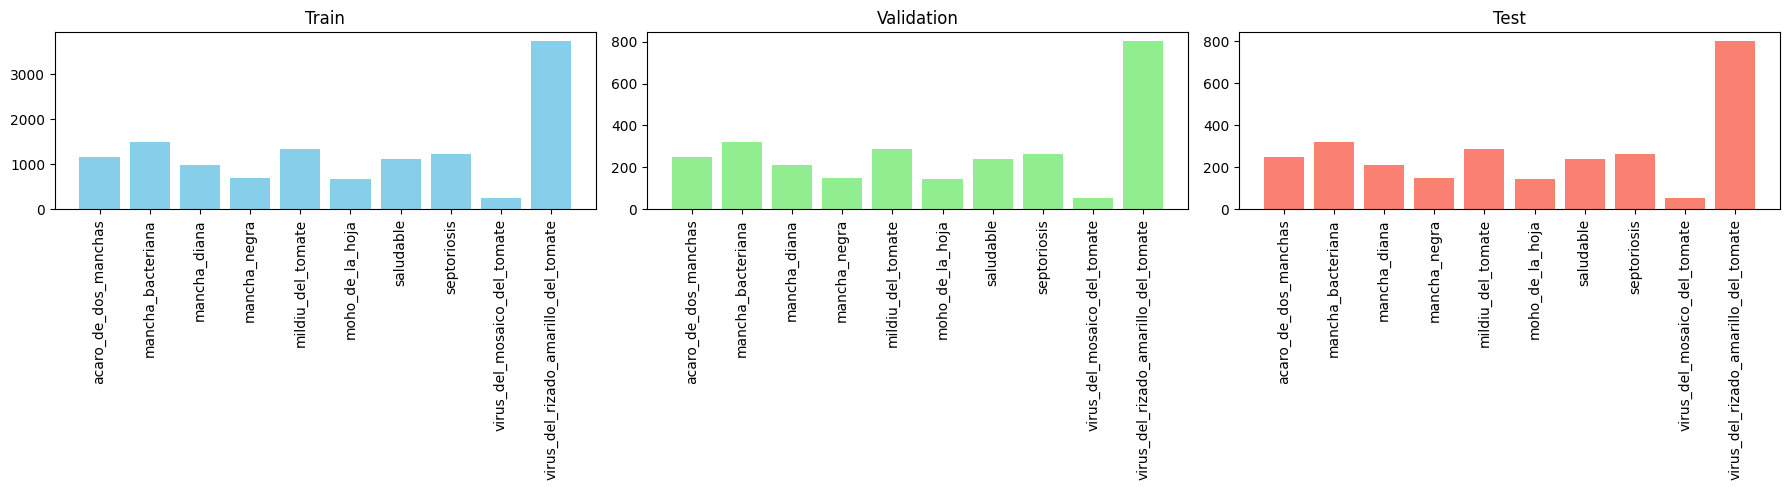

In [ ]:
def contar_imagenes_por_categoria(base_dir):
    categorias = []
    cantidades = []
    for categoria in sorted(os.listdir(base_dir)):
        categoria_path = os.path.join(base_dir, categoria)
        if os.path.isdir(categoria_path):
            count = len(os.listdir(categoria_path))
            categorias.append(categoria)
            cantidades.append(count)
    return pd.DataFrame({'Categoría': categorias, 'Cantidad de imágenes': cantidades})

train_counts = contar_imagenes_por_categoria(os.path.join(data_dir, 'train'))
val_counts = contar_imagenes_por_categoria(os.path.join(data_dir, 'val'))
test_counts = contar_imagenes_por_categoria(os.path.join(data_dir, 'test'))

print("Conjunto de entrenamiento:")
display(train_counts)
print("\n Conjunto de validación:")
display(val_counts)
print("\n Conjunto de prueba:")
display(test_counts)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(train_counts['Categoría'], train_counts['Cantidad de imágenes'], color='skyblue')
axes[0].set_title('Train')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(val_counts['Categoría'], val_counts['Cantidad de imágenes'], color='lightgreen')
axes[1].set_title('Validation')
axes[1].tick_params(axis='x', rotation=90)

axes[2].bar(test_counts['Categoría'], test_counts['Cantidad de imágenes'], color='salmon')
axes[2].set_title('Test')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


**IMAGENES SELECCIONADAS DE CADA CATEGORIA**

In [ ]:
train_dir = os.path.join(data_dir, 'train')
categories = os.listdir(train_dir)
IMG_SIZE = (224, 224)

plt.figure(figsize=(12, len(categories) * 3))

for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    sample_images = random.sample(images, min(3, len(images)))  # elige 3 aleatorias

    plt.subplot(len(categories), 1, i + 1)
    plt.text(0.5, 0.5, category.upper(), fontsize=14, ha='center', va='center')
    plt.axis('off')

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(category_path, img_name)
        img = image.load_img(img_path, target_size=IMG_SIZE)
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.show()


NameError: name 'os' is not defined

**CONSTRUCCION DEL MODELO CNN**

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**ENTRENAMIENTO**

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4040 - loss: 1.7461

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


398/398 ━━━━━━━━━━━━━━━━━━━━ 3700s 9s/step - accuracy: 0.4043 - loss: 1.7454 - val_accuracy: 0.6477 - val_loss: 1.0201
Epoch 2/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - accuracy: 0.6586 - loss: 0.9987 - val_accuracy: 0.7618 - val_loss: 0.7172
Epoch 3/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 597s 1s/step - accuracy: 0.7284 - loss: 0.8013 - val_accuracy: 0.8000 - val_loss: 0.5759
Epoch 4/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.7557 - loss: 0.7206 - val_accuracy: 0.7952 - val_loss: 0.6070
Epoch 5/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.7811 - loss: 0.6301 - val_accuracy: 0.7758 - val_loss: 0.6739
Epoch 6/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - accuracy: 0.8042 - loss: 0.5739 - val_accuracy: 0.8169 - val_loss: 0.5054
Epoch 7/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.8207 - loss: 0.5156 - val_accuracy: 0.8411 - val_loss: 0.4494
Epoch 8/25
398/398 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.8413 - loss: 0.4919 - val_accuracy: 0.89

**CURVA DE APRENDIZAJE**

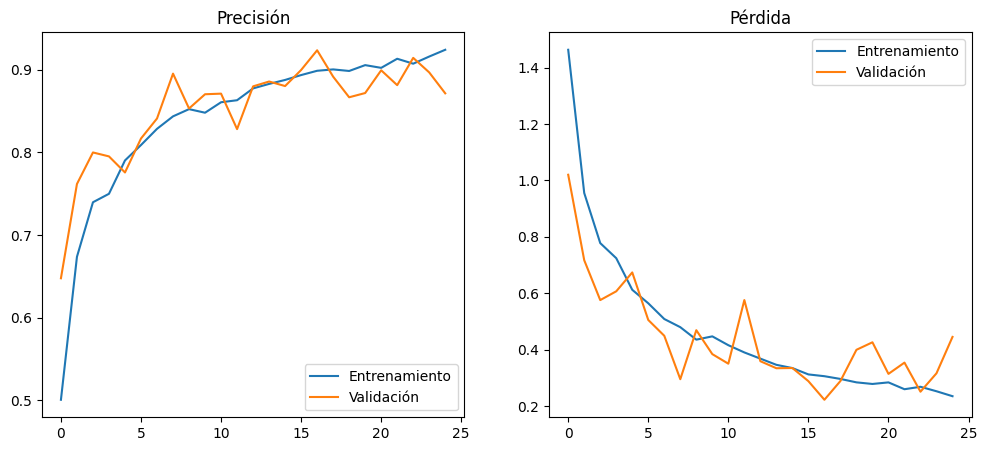

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()
plt.show()

**MATRIZ DE CONFUSION Y REPORTE**

85/85 ━━━━━━━━━━━━━━━━━━━━ 989s 12s/step


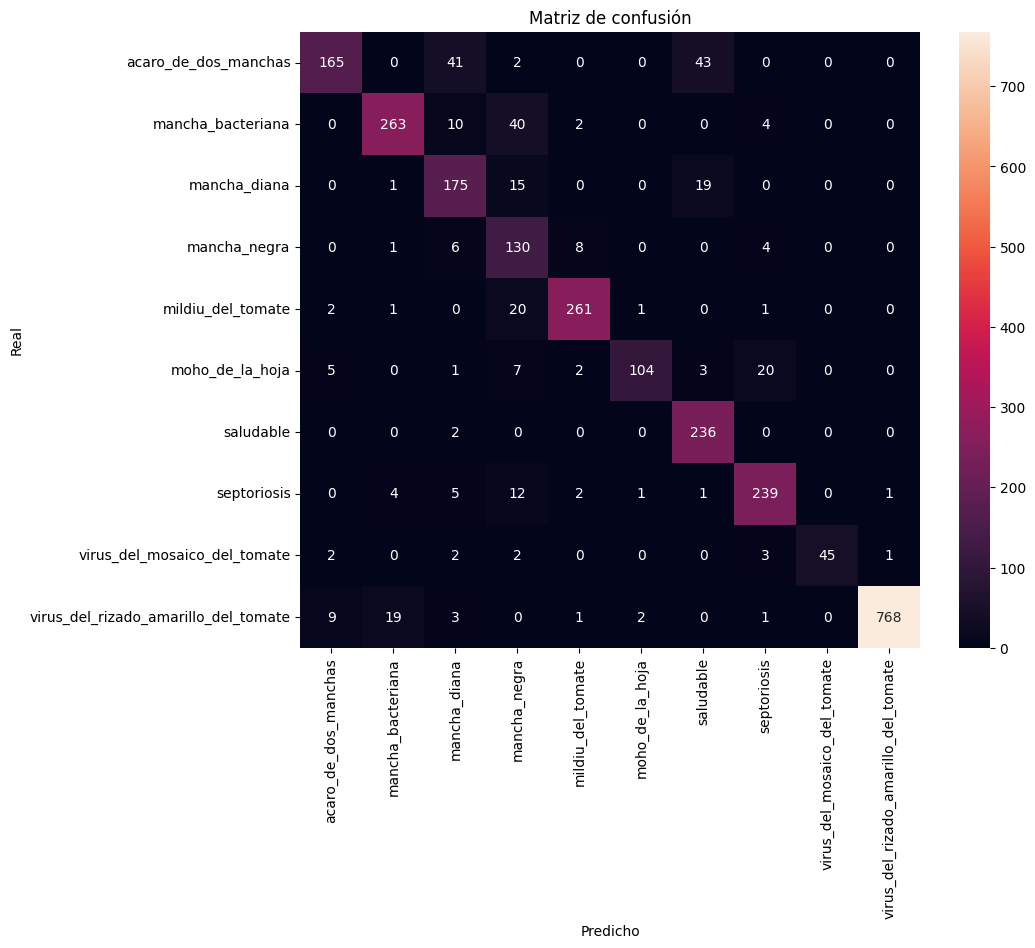

                                      precision    recall  f1-score   support

                acaro_de_dos_manchas       0.90      0.66      0.76       251
                   mancha_bacteriana       0.91      0.82      0.87       319
                        mancha_diana       0.71      0.83      0.77       210
                        mancha_negra       0.57      0.87      0.69       149
                   mildiu_del_tomate       0.95      0.91      0.93       286
                     moho_de_la_hoja       0.96      0.73      0.83       142
                           saludable       0.78      0.99      0.87       238
                         septoriosis       0.88      0.90      0.89       265
        virus_del_mosaico_del_tomate       1.00      0.82      0.90        55
virus_del_rizado_amarillo_del_tomate       1.00      0.96      0.98       803

                            accuracy                           0.88      2718
                           macro avg       0.87      0.85     

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title('Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=test_gen.class_indices.keys()))



**GUARDAR MODELO H5**

In [ ]:
model.save('/content/tomato_leaf_classifier.h5')


**CARGAR MODELO Y PROBAR UNA IMAGEN**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('/content/tomato_leaf_classifier.h5')

# Ensure IMG_SIZE matches the model's input size (128, 128)
IMG_SIZE = (128, 128)

img_path = '/content/drive/MyDrive/pruebas/prueba_mildiu_del_tomate.JPG'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
# Imagen
ax_img.imshow(orig_img)
ax_img.axis("off")
ax_img.set_title("Imagen de entrada")

predictions = model.predict(img_array)[0]

# Get class labels from the test generator
class_labels = list(test_gen.class_indices.keys())

for label, prob in zip(class_labels, predictions):
    print(f"{label}: {prob*100:.2f}%")

ModuleNotFoundError: No module named 'tensorflow'